In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classi

In [2]:
#download mnist dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()

#flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))


In [3]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None # this disables synaptic filtering

    # n_type = nengo.PoissonSpiking(nengo.RectifiedLinear())
    # n_type = nengo.RectifiedLinear()
    n_type = nengo.SpikingRectifiedLinear() 

    n_in = 784
    inter_dim = 128

    inp_node = nengo.Node(np.zeros(n_in))

    # first layer
    enc1 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(inp_node, enc1.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    enc2 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(enc1.neurons, enc2.neurons, transform=nengo_dl.dists.Glorot())

    # output layer
    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(enc2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    # probes
    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")


    # from mnist example
    # out_p = nengo.Probe(outp, label="out_p")
    # out_p_filt = nengo.Probe(outp, synapse=0.1, label="out_p_filt")



In [4]:
minibatch_size = 50

with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
  sim.predict(np.ones((minibatch_size, 1, n_in)));

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:467: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Construction finished in 0:00:00                                               
|##############Constructing graph: build stage (78%)             | ETA: 0:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:1030: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  "Running for one timestep, but the network contains "


## Training

A variety of training techniques are available. The current training technique mirrors traditional neural network training, mapping roughly to TensorFlow

In [5]:
# changing the model to more closely match how tensorflow works

for ens in auto_net.all_ensembles:
  ens.gain = nengo.dists.Choice([1]) # set all gains to 1
  ens.bias = nengo.dists.Choice([0]) # set all biases to 0 

# disables synaptic filtering.. eventually we want to use it though
for conn in auto_net.all_connections:
  conn.synapse = None 

In [6]:
# reshaping the data again for use in simulation, since with spiking networks simulations are temporal
# shape: (batch_size, n_steps, n)

train_data = train_data[:, None, :]

# # when testing our network with spiking neurons we will need to run it 
# # over time, so we repeat the input/target data for a number of 
# # timesteps.

n_steps = 100
test_data = np.tile(test_data[:, None, :], (1, n_steps, 1))


In [7]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
  sim.compile(optimizer = tf.optimizers.RMSprop(1e-3), 
              loss = {p_c: tf.losses.mse, # mean squared error as loss function
                      p_c_filt: None}
             ) 

  # run training loop. If using spiking neurons, this converts the model to a rate based approximation and then does training
  sim.fit(train_data, train_data, epochs = 10)
  sim.freeze_params(auto_net)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|##############Constructing graph: build stage (35%)             | ETA: 0:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f0b77c77908> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens
/home/igr/.local/lib/python3.6/site-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f0b9bb85898> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens
/home/igr/.local/lib/python3.6/site-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f0b77c77c88> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or interce

Construction finished in 0:00:00                                               
Epoch 1/10
|##############Constructing graph: build stage (92%)########     | ETA: 0:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:1777: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  len(objects),


1200/1200 [==============================] - 13s 11ms/step - loss: 1409.6179 - probe_loss: 1409.6179
Epoch 2/10
1200/1200 [==============================] - 13s 11ms/step - loss: 945.0902 - probe_loss: 945.0902
Epoch 3/10
1200/1200 [==============================] - 13s 11ms/step - loss: 859.1498 - probe_loss: 859.1498
Epoch 4/10
1200/1200 [==============================] - 13s 11ms/step - loss: 819.3806 - probe_loss: 819.3806
Epoch 5/10
1200/1200 [==============================] - 13s 11ms/step - loss: 792.6276 - probe_loss: 792.6276
Epoch 6/10
1200/1200 [==============================] - 14s 11ms/step - loss: 772.7725 - probe_loss: 772.7725
Epoch 7/10
1200/1200 [==============================] - 14s 11ms/step - loss: 758.3553 - probe_loss: 758.3553
Epoch 8/10
1200/1200 [==============================] - 13s 11ms/step - loss: 738.1925 - probe_loss: 738.1925
Epoch 9/10
1200/1200 [==============================] - 13s 11ms/step - loss: 713.2304 - probe_loss: 713.2304
Epoch 10/10
1200/12

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
200/200 [==============================] - 317s 2s/step - loss: 20772.9355 - probe_loss: 20772.9355
Test error:  OrderedDict([('loss', 20772.935546875), ('probe_loss', 20772.935546875)])


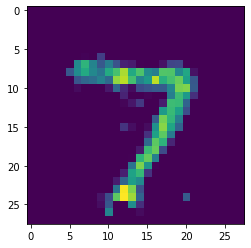

In [8]:
for conn in auto_net.all_connections:
    conn.synapse = 0.005

with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:

  sim.compile(optimizer = tf.optimizers.RMSprop(1e-3), 
              loss = {p_c: tf.losses.mse, # mean squared error as loss function
                      p_c_filt: None}
             )
  # evaluate performance on test set
  print("Test error: ", sim.evaluate(test_data, {p_c: test_data}))

  # display example output
  output = sim.predict(test_data[:minibatch_size]) # runs sim.predict on the first minibatch of the data 
  plt.figure()
  # plt.imshow(output[p_c][0].reshape((28, 28)))
  plt.imshow(output[p_c_filt][0, 99].reshape((28, 28)))